In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import find_peaks
import time
import sounddevice as sd
import noisereduce as nr

from spectrogram import *

In [2]:
sound_data = SoundData()
spectrum_factory = Spectrum(sound_data=sound_data, linewidth=2)

In [3]:
trange = np.arange(0,3,sound_data.sampling_dt)
O = 420 #Hz
sound_data.set(np.cos(2*np.pi*O*trange))
sound_data.play()

In [4]:
ndata = int(spectrum_factory.timestep/sound_data.sampling_dt)
x = np.linspace(-1,1,ndata+1)
power = 6
fx = 1-x**power/(1+x**power)
y = np.concatenate(( 1-fx[int(ndata/2):-1], fx, 1-fx[1:int(ndata/2)]))
plt.plot(y, '-')
plt.axhline(0.5, color='lightgrey', linestyle='--')

AttributeError: 'Spectrum' object has no attribute 'timestep'

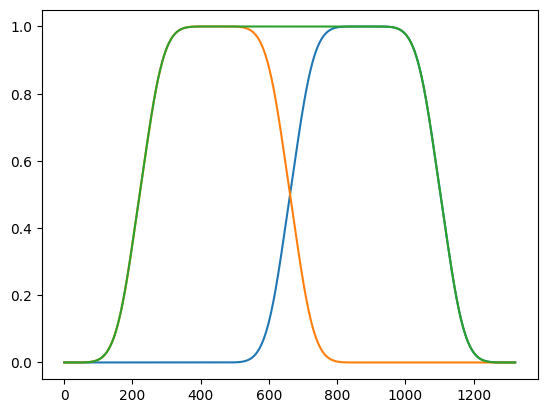

In [76]:
y1 = np.concatenate((np.zeros(shape=(ndata,)) , y ))
y2 = np.concatenate((y, np.zeros(shape=(ndata,)) ))
plt.plot(y1)
plt.plot(y2)
plt.plot(y1+y2)

c:\Users\antal\Documents\Work\Mikrofonok\mic_env\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\antal\Documents\Work\Mikrofonok\mic_env\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


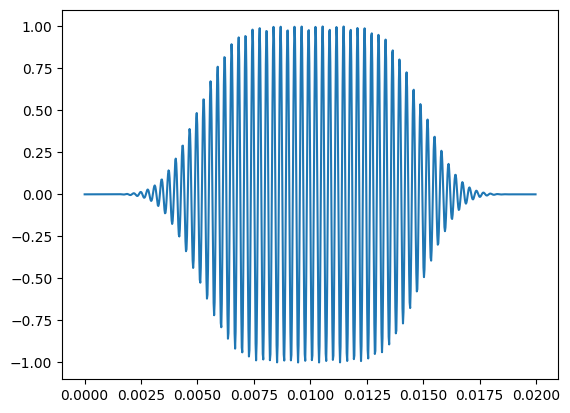

In [113]:
trange = np.arange(0,2*spect.timestep,spect.sampling_dt)
wavesamples = np.array([ y*np.exp(-2*1j*np.pi*f*trange) for f in spect.frequencies])
plt.plot(trange, wavesamples[200])

In [ ]:
duration = 2 # seconds
starttimes = np.arange(0, duration, spect.timestep)
phases = np.array( [ [np.exp(-2*1j*np.pi*nu*ti) for nu in spect.frequencies] for ti in starttimes] )
spectrum = np.zeros(shape = (len(starttimes) ,len(spect.frequencies)))


((200, 240), (200, 240))

In [136]:
spectrum = np.zeros(shape = (300,len(spect.frequencies)))


duration = spectrum.shape[0]*spect.timestep   # seconds
starttimes = np.arange(0, duration, spect.timestep)
phases = np.array( [ [np.exp(-2*1j*np.pi*nu*ti) for nu in spect.frequencies] for ti in starttimes] )


In [137]:
spectrum[:,150] = 1.0
spectrum.shape, phases.shape

((300, 240), (300, 240))

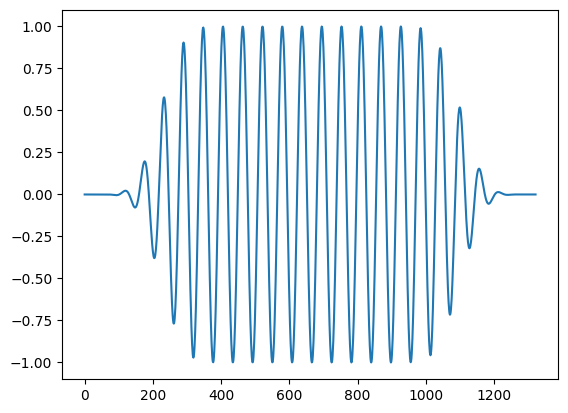

In [143]:
generator = (spectrum*phases)@wavesamples
data = generator[0]

newdata = np.concatenate(( np.zeros(data.shape[0]-ndata), generator[1]))
data = np.concatenate((data, np.zeros(shape=(ndata,)))) + newdata
plt.plot(data.real)

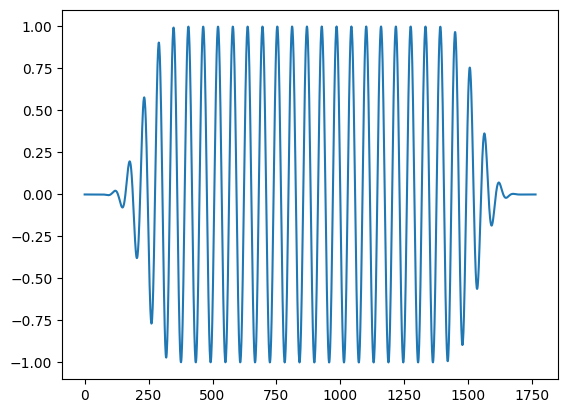

In [144]:
newdata = np.concatenate(( np.zeros(data.shape[0]-ndata), generator[2]))
data = np.concatenate((data, np.zeros(shape=(ndata,)))) + newdata
plt.plot(data.real)

In [231]:
def synthesize(spect, spectrum, wavesamples):
    #start providing phases
    ndata = int(spect.timestep/spect.sampling_dt)
    duration = spectrum.shape[0]*spect.timestep   # seconds
    starttimes = np.arange(0, duration, spect.timestep)
    phases = np.array( [ [np.exp(-2*1j*np.pi*nu*ti) for nu in spect.frequencies] for ti in starttimes] )
    generator = (spectrum*phases)@wavesamples
    #generator = spectrum@wavesamples
    
    #from the generator we generate the data
    data = generator[0]
    
    for gen in generator[1:]:
        data = np.concatenate((data, np.zeros(shape=(ndata,)))) + np.concatenate(( np.zeros(data.shape[0]-ndata), gen))
    
    return data.real

In [232]:
#this is the incoming spectrum to sysnthetize
dtact = 0.25 #sec
dn = int(dtact/spect.timestep)
spectrum = np.zeros(shape = (spect.Noctave*dn, len(spect.frequencies)))

for i in range(spect.Noctave):
    spectrum[i*dn:(i+1)*dn,120+i] = 1.0
data = synthesize(spect, spectrum, wavesamples)
channel_0_int16 = np.int16(data / np.max(np.abs(data)) * 32767)
sd.play(channel_0_int16, samplerate=spect.sample_rate)
sd.wait()

In [233]:
notes = { 
    'C' : 120,
    'C#': 122,
    'D' : 124,
    'D#': 126,
    'E' : 128,
    'F' : 130,
    'F#': 132,
    'G' : 134,
    'G#': 136,
    'A' : 138,
    'A#': 140,
    'B' : 142,
    'c' : 144
}
notes['c']

144

In [234]:
song = 'C:1,E:1,C:1,E:1,G:2,G:2,C:1,E:1,C:1,E:1,G:2,G:2,c:1,B:1,A:1,G:1,F:2,A:2,G:1,F:1,E:1,D:1,C:2,C:2'
songlist = song.split(',')
song_length= np.sum([int(note.split(':')[1]) for note in songlist])

#this is the incoming spectrum to sysnthetize
dtact = 0.2 #sec
dn = int(dtact/spect.timestep)
spectrum = np.zeros(shape = (song_length*dn, len(spect.frequencies)))
i=0
for u in songlist:
    note, dt = u.split(':')
    inext = i + int(dt)
    spectrum[i*dn:inext*dn,notes[note]] = 1.0
    i = inext
    
data = synthesize(spect, spectrum, wavesamples)
channel_0_int16 = np.int16(data / np.max(np.abs(data)) * 32767)
sd.play(channel_0_int16, samplerate=spect.sample_rate)
sd.wait()

In [230]:
#this is the incoming spectrum to sysnthetize
dtact = 0.6 #sec
dn = int(dtact/spect.timestep)

song1 = 'C:1,E:1,G:1,c:2'
songlist = song1.split(',')
song_length= np.sum([int(note.split(':')[1]) for note in songlist])
spectrum1 = np.zeros(shape = (song_length*dn, len(spect.frequencies)))
i=0
for u in songlist:
    note, dt = u.split(':')
    inext = i + int(dt)
    spectrum1[i*dn:inext*dn,notes[note]] = 1.0
    spectrum1[i*dn:inext*dn,notes[note]+24] = 1.0
    spectrum1[i*dn:inext*dn,notes[note]+48] = 1.0
    i = inext
spectrum = spectrum1

song2 = 'C:2,E:1,G:2'
songlist = song2.split(',')
song_length= np.sum([int(note.split(':')[1]) for note in songlist])
spectrum2 = np.zeros(shape = (song_length*dn, len(spect.frequencies)))
i=0
for u in songlist:
    note, dt = u.split(':')
    inext = i + int(dt)
    spectrum2[i*dn:inext*dn,notes[note]] = 1.0
    spectrum2[i*dn:inext*dn,notes[note]+24] = 1.0
    spectrum2[i*dn:inext*dn,notes[note]+48] = 1.0

    i = inext
spectrum = spectrum1 + spectrum2
data = synthesize(spect, spectrum, wavesamples)
channel_0_int16 = np.int16(data / np.max(np.abs(data)) * 32767)
sd.play(channel_0_int16, samplerate=spect.sample_rate)
sd.wait()

In [213]:
np.random.randint(-1,1)

0